In [1]:
import pickle
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib.colors import Normalize

# sstの陸面をマスクする関数
def mask(x):
    m = ma.masked_where(x>9999, x)
    z = ma.masked_where(m==0, m)
    #f = ma.filled(z, np.nan) # for masking
    f = ma.filled(z, 0) # for filing with 0
    return f

# (緯度、経度、時間)の三次元情報を => (空間, 時間)の二次元行列に変換する関数
def latlon_to_X(var):
    # 三次元情報それぞれのshapeを取得
    imt, jmt, tmt = var.shape
    # 出力行列Xのshapeを決定
    X = np.zeros((imt*jmt, tmt))
    
    # 行列に変換
    cc = 0 # 行列Xの空間次元のインデックス
    for ii in range(0, imt):
        for jj in range(0, jmt):
            # マスクされている場合は行列に含めない
            if np.isnan(var[ii, jj, 0]) == False:
                X[cc, :] = np.squeeze(var[ii, jj, :])
                cc = cc + 1
    X = np.squeeze(X[0:cc, :]) #squeezeは長さが1の軸が存在する場合に取り除くための保険
    return X

# 二次元行列を三次元に変換する関数
def X_to_latlon(X):
    #　対象とする地域の降水データグリッドサイズが20x20の行列なので、手動でimt,jmtを設定
    imt, jmt = 20, 20
    
    SVDs = np.zeros((imt, jmt))
    
    # 行列を三次元情報に復元
    cc = 0
    for ii in range(0, imt):
        for jj in range(0, jmt):
            SVDs[ii, jj] = X[cc]
            cc += 1
    
    return SVDs

def PQ_to_latlon(P, var):
    # 行列のサイズを得る
    smt, mmt = P.shape
    imt, jmt, kmt = var.shape
    
    # 出力するデータ行列を初期化しておく(この時、最大サイズ(すべて海)を仮定)
    SVDs = np.zeros((imt, jmt, mmt))
    
    # lat-lon行列の作成
    cc = 0 # 何番目のNaNでなはない格子なのかを数えるカウンター
    for ii in range(0, imt):
        for jj in range(0, jmt):
            # マスクされている場合は行列に含めない
            if np.isnan(var[ii, jj, 0]) == False:
                SVDs[ii, jj, :] = P[cc, :]
                cc = cc + 1
            else:
                SVDs[ii, jj, :] = np.nan
    return SVDs

# sstを可視化するための関数
def show_sst(image, img_extent, vmin=-1.5, vmax=1.5):
    projection = ccrs.PlateCarree(central_longitude=180)
    cm = plt.get_cmap('seismic')

    fig = plt.figure()
    ax = plt.subplot(projection=projection)
    ax.coastlines()
    mat = ax.matshow(image,
                     origin='upper',
                     extent=img_extent,
                     transform=projection,
                     cmap=cm,
                     norm=Normalize(vmin=vmin, vmax=vmax))
    cbar = fig.colorbar(mat, 
                        extend='both',
                        spacing='proportional',
                        orientation='horizontal')
    plt.show()

# prcpを可視化するための関数
def show_prcp(image, vmin=-1.5, vmax=1.5):
    projection =ccrs.PlateCarree(central_longitude=180)
    cm = plt.get_cmap('BrBG')
    img_extent = (-90, -70, 5, 25) # location=(N5-25, #90-110)
    
    fig = plt.figure()
    ax = plt.subplot(projection=projection)
    ax.coastlines()
    mat = ax.matshow(image,
                     origin='upper',
                     extent=img_extent,
                     transform=projection,
                     cmap=cm,
                     norm=Normalize(vmin=vmin, vmax=vmax)) # vminとvmaxは結果を見て見やすいように調整
    cbar = fig.colorbar(mat, 
                        extend='both',
                        spacing='proportional',
                        orientation='vertical')
    plt.show()

(5930, 24, 72, 4) (5930, 400)
(5930, 24, 72) (5930, 400)
(1000, 24, 72) (1000, 400)


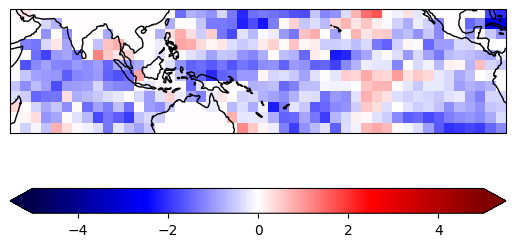

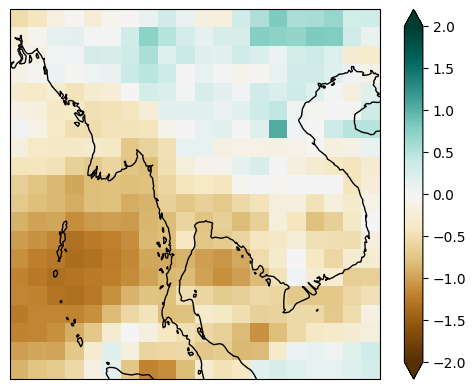

In [2]:
# データの用意
# 訓練/テストデータのディレクトリを参照
testdir = '/docker/mnt/d/research/D2/cnn3/test'
val_path = testdir + '/continuous/seed1_predictors_coarse_std_Apr_msot-pr_1x1_std_MJJASO_thailand.pickle'

# データセットのロード
with open(val_path, 'rb') as f:
    data = pickle.load(f)
x_train, y_train, x_val, y_val, val_dct = data['x_train'], data['y_train'], data['x_val'], data['y_val'], data['val_dct']
val_model, val_year = val_dct['model'], val_dct['year'] # validationモデルと年のdict
print(x_train.shape, y_train.shape)
          
# 訓練データ 
sst_train = x_train[:, :, :, 2]
prcp_train = y_train
print(sst_train.shape, prcp_train.shape)

# テストデータ
sst_test = x_val[:, :, :, 2]
prcp_test = y_val
print(sst_test.shape, prcp_test.shape)

# テストデータセットに含まれるsstとprcpを確認 index=0
index = 0
img_extent = (-135, 105, -30, 30)

sst_tmp = sst_test[index, :, :]
sst_masked = mask(sst_tmp)
ocean = sst_masked[6:18, 9:57]
show_sst(ocean, img_extent, vmin=-5, vmax=5)

prcp_tmp = prcp_test[index, :].reshape(20, 20)
show_prcp(prcp_tmp, vmin=-2, vmax=2)